# Corrective RAG
- Focus is on improving the accuracy and relevance of generated docs by incorporating mechanisms for self reflection and self-grading of retrieved documents
- It evaluates the quality of generated docs and applies corrective measures (e.g rewriting queries or augmenting with web search) when needed

## Limitations of traditional RAGs
- Traditional RAG systems heavily rely on accuracy of retrieved documents. If the retrieved information is flawed or incomplete, the generated response can also be inaccurate

## Corrective RAG's core components:
- **Retrieval Evaluator**: Assesses the quality and relevance of retrieved documents
- **Generative Model**: Generates an initial response based on retrieved information
- **Refinement and Correction**: CRAG employs strategies like Knowledge Refinement or web search to addres issues identified by the retrieval evaluator

## Benefits of CRAG:
- Improved Accuracy
- Enhanced Relevance
- Increased Robustness

In [1]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')

In [2]:
## Build an index
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings


# embeddings
embd = OpenAIEmbeddings()

# Docs to index
urls = [
    'https://lilianweng.github.io/posts/2023-06-23-agent/',
    'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/',
    'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/',
]

# load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# split text
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap=0)
doc_splits = text_splitter.split_documents(docs_list)

## Vector stores
vector_store = FAISS.from_documents(
    documents = doc_splits,
    embedding=OpenAIEmbeddings()
)

## vector store as retriever
retriever = vector_store.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
## Retrieval grader
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

# Data Model
class GradeDocuments(BaseModel):
    '''Binary Score for relevance check on retrieved documents'''
    
    binary_score:str = Field(description='Documents are relevant to question \'yes\' or \'no\'')
    
## LLM with function call
llm = ChatOpenAI(model='gpt-4o', temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# prompt
system = """ You're a grader assessing relevance of the retrieved document to a user question. \n
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
"""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system),
        ('human', 'Retrieved document: \n\n {document} \n\n User questions: {question}')
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = 'agent memory'
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({'question':question, 'document':doc_txt}))

binary_score='yes'


In [4]:
## generate
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# prompt
prompt = hub.pull('rlm/rag-prompt')

#LLM
llm = ChatOpenAI(model='gpt-4o', temperature=0)

# post processing
def format_docs(docs):
    return '\n\n'.join(doc.page_content for doc in docs)

# chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({'context': docs, 'question':question})
print(generation)

In LLM-powered autonomous agents, memory is divided into short-term and long-term components. Short-term memory involves in-context learning, while long-term memory allows the agent to retain and recall information over extended periods, often using an external vector store for fast retrieval. This memory system enables agents to learn from past experiences and improve future actions.


In [5]:
## Question rewriter

#LLM
llm = ChatOpenAI(model='gpt-4o', temperature=0)

# prompt
system = ''' You are a question re-writer that converts an input question to a better version that is optimized \n
for web search. Look at my input and try to reason about the underlying semantic intent/ meaning
'''

rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system),
        ('human', 'Here is the initial question: \n\n {question} \n Generate an improved question')
    ]
)

question_rewriter = rewrite_prompt | llm | StrOutputParser()
question_rewriter.invoke({'question':question})

'What is agent memory and how does it function in artificial intelligence systems?'

In [6]:
# Search
from langchain_community.tools.tavily_search import TavilySearchResults
websearchtool = TavilySearchResults(k=3)

/var/folders/15/xbwr_x_d51sf0lj4mptglw6h0000gn/T/ipykernel_50901/484733239.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  websearchtool = TavilySearchResults(k=3)


In [7]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph

    Attributes:
       question: question
       generation: LLM generation
       web_search: whether to add web search
       documents: list of documents
    """
    
    question:str
    generation:str
    web_search:str
    documents: List[str]

In [9]:
from langchain.schema import Document
def retrieve(state):
    """Retrieve documents 

    Args:
        state (dict): The current state of graph
        
    Returns:
        state (dict): New key added to the state, documents that contain retrieved documents
    """
    print('--- RETRIEVE ---')
    question = state['question']
    # Retrieval
    documents = retriever.invoke(question)
    return {'documents': documents, 'question':question}    

def generate(state):
    """Generate answer

    Args:
        state (dict): The current state of the graph
    
    Return: 
        state (dict):  New key added to the state, generation, that contains LLM generation
    """
    print('--- GENERATE ---')
    question = state['question']
    documents = state['documents']
    
    ## RAG generation
    generation = rag_chain.invoke({'context': documents,'question':question})
    return {'documents': documents,'question':question, 'generation':generation}

def grade_documents(state):
    """Determines whether the retrieved documents are relevant to the question

    Args:
        state (dict): Current state of the graph
        
    Returns:
        state (dict): Updates the documents key with only the filtered relevant documents
    """
    print('--- CHECK DOCUMENT RELEVANCE TO THE QUESTION ---')
    question = state['question']
    documents = state['documents']
    
    # Score each doc
    filtered_docs = []
    web_search = 'No'
    for d in documents:
        score= retrieval_grader.invoke({
            'question': question, 'document':d.page_content
        })
        
        grade = score.binary_score
        if grade == 'yes':
            print('--- GRADE: DOCUMENT RELEVANT ---')
            filtered_docs.append(d)
        else:
            print('--- GRADE: DOCUMENT NOT RELEVANT ---')
            web_search = 'yes'
            continue
    return {'documents':documents, 'question': question, 'web_search': web_search}

def transform_query(state):
    """Transform the query to produce a better question

    Args:
        state (dict): The current state of the graph
        
    Returns:
        state (dict): Updates the key with re-phrased question
    """
    
    print('--- TRANSFORM QUERY ---')
    question = state['question']
    documents = state['documents']
    
    # rewrite question
    better_question = question_rewriter.invoke({'question':question})
    return {'documents':documents, 'question':question}

def web_search(state):
    """Web search based on rephrased question

    Args:
        state (dict): The current graph state
        
    Returns:
        state (dict): Updates documents key with appended web results
    """
    
    print('--- WEB SEARCH ---')
    question = state['question']
    documents = state['documents']
    
    # web search
    docs = websearchtool.invoke({'query':question})
    web_results = '\n'.join([d['content'] for d in docs])
    web_results= Document(page_content=web_results)
    documents.append(web_results)
    return {'documents':documents, 'question':question}

def decide_to_generate(state):
    """Determines whether to generate an answer or re-generate the question

    Args:
        state (dict): The current graph state
        
    Returns:
        str: Binary decision for next node call
    """
    
    print('--- ASSESS GRADED DOCUMENTS ---')
    web_search = state['web_search']
    if web_search == 'yes':
        print(" --- DECISION: DOCS NOT RELEVANT TO QUERY, TRANSFORM QUERY ---")
        return 'transform_query'
    else:
        print('--- DECISION: DOCS RELEVANT TO QUERY, GENERATE ANSWER ---')
        return 'generate'


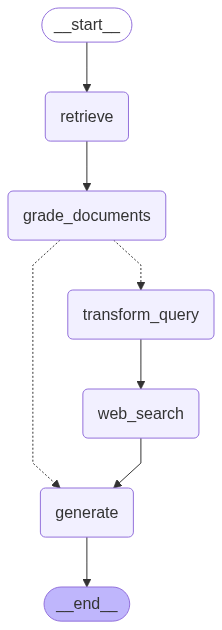

In [10]:
## build the graph
from langgraph.graph import START,StateGraph, END
from IPython.display import Image, display
workflow = StateGraph(GraphState)

## add nodes
workflow.add_node('retrieve', retrieve)
workflow.add_node('grade_documents', grade_documents)
workflow.add_node('generate', generate)
workflow.add_node('transform_query', transform_query)
workflow.add_node('web_search', web_search)

# build graph
workflow.add_edge(START, 'retrieve')
workflow.add_edge('retrieve', 'grade_documents')
workflow.add_conditional_edges(
    'grade_documents',
    decide_to_generate,
    {
        'transform_query': 'transform_query',
        'generate': 'generate'
    }
)
workflow.add_edge('transform_query', 'web_search')
workflow.add_edge('web_search', 'generate')
workflow.add_edge('generate', END)

graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
# invoke graph
graph.invoke({'question': 'What is an agentic RAG?'})

--- RETRIEVE ---
--- CHECK DOCUMENT RELEVANCE TO THE QUESTION ---
--- GRADE: DOCUMENT RELEVANT ---
--- GRADE: DOCUMENT NOT RELEVANT ---
--- GRADE: DOCUMENT NOT RELEVANT ---
--- GRADE: DOCUMENT NOT RELEVANT ---
--- ASSESS GRADED DOCUMENTS ---
 --- DECISION: DOCS NOT RELEVANT TO QUERY, TRANSFORM QUERY ---
--- TRANSFORM QUERY ---
--- WEB SEARCH ---
--- GENERATE ---


{'question': 'What is an agentic RAG?',
 'generation': 'An agentic RAG (Retrieval-Augmented Generation) is an advanced system that incorporates AI agents into the RAG pipeline to enhance adaptability, accuracy, and functionality. These agents manage the retrieval and generation processes, allowing for multi-step reasoning, dynamic querying, and decision-making. This approach enables more complex workflows and improves the overall performance of AI applications compared to traditional RAG systems.',
 'web_search': 'yes',
 'documents': [Document(id='a442a105-1e28-4bda-a0c3-ea5131a7a718', metadata={'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log", 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can 